# Homework 9: Normal Distribution. Variance of Sample Means Bootstrap, Resampling, CLT

**Reading**: 
* [Estimation](https://www.inferentialthinking.com/chapters/13/Estimation.html)
* [Why the Mean Matters](https://www.inferentialthinking.com/chapters/14/Why_the_Mean_Matters.html)
* [the variance of sample means](https://inferentialthinking.com/chapters/14/5/Variability_of_the_Sample_Mean.html)
* [the normal distribution](https://www.inferentialthinking.com/chapters/14/3/SD_and_the_Normal_Curve.html).

In [1]:
# Run this cell, but please don't change it. 

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# 1. Normal Distributions

When we visualize the distribution of a sample, we are often interested in the mean and the standard deviation of the sample (for the rest of this homework, we will abbreviate “standard deviation” as “SD”). These two summary statistics can give us a bird’s eye view of the distribution - by letting us know where the distribution sits on the number line and how spread out it is, respectively. 

**Question 1.1.** The next cell loads the table `births` from lecture, which is a large random sample of US births and includes information about mother-child pairs. 

Plot the distribution of mother’s ages from the table. Don’t change the last line, which will plot the mean of the sample on the distribution itself.

<!--
BEGIN QUESTION
name: q1_1
-->

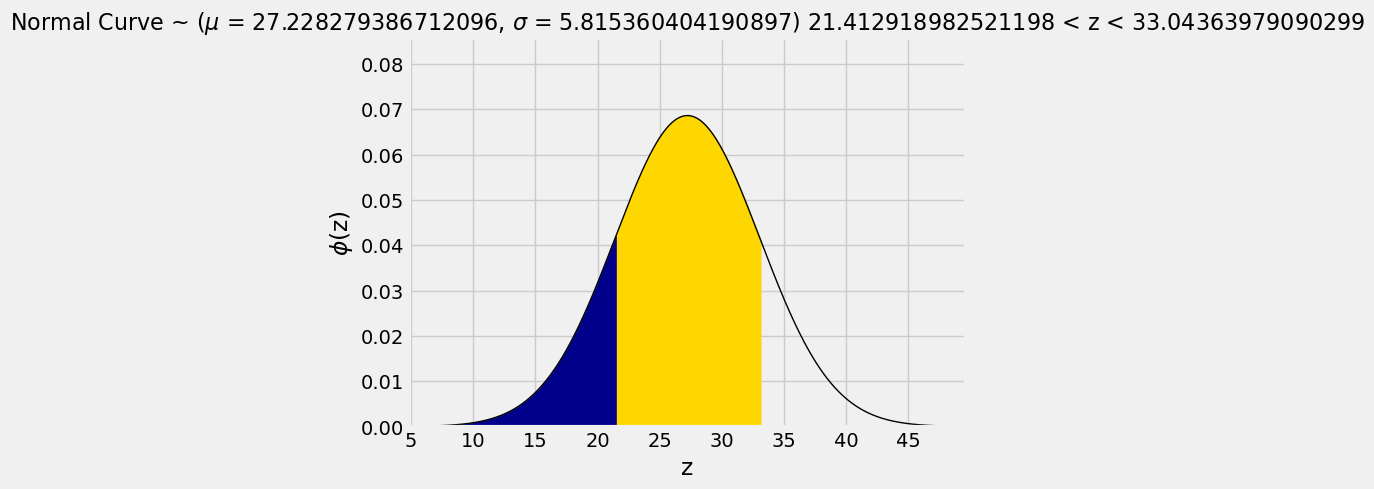

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


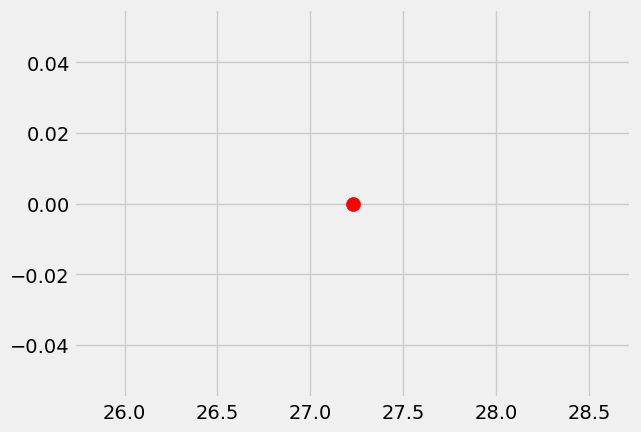

In [7]:
births = Table.read_table('baby.csv')
mean_age = np.mean(births.column("Maternal Age")) 
std_age = np.std(births.column("Maternal Age"))
plot_normal_cdf(lbound = mean_age - std_age, rbound = mean_age + std_age, mean = mean_age, sd = std_age)

# Do not change this line
plt.scatter(np.mean(births.column("Maternal Age")), 0, color='red', s=100, zorder=2);
births

From the plot above, we can see that the mean is the center of gravity or balance point of the distribution. If you cut the distribution out of cardboard, and then placed your finger at the mean, the distribution would perfectly balance on your finger. Since the distribution above is right skewed (which means it has a long right tail), we know that the mean of the distribution is larger than the median, which is the “halfway” point of the data. Conversely, if the distribution had been left skewed, we know the mean would be smaller than the median.

Run the following cell to compare the mean (red) and median (green) of the distribution of mothers ages.

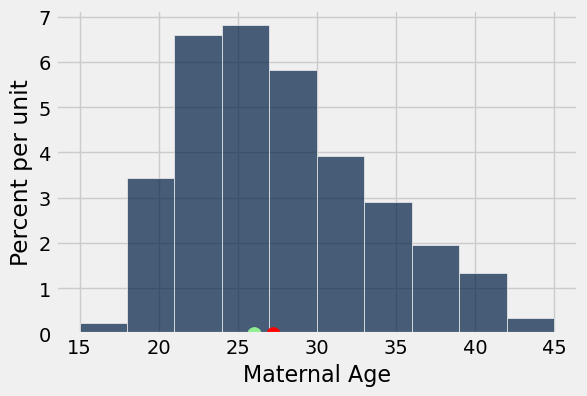

In [8]:
births.hist("Maternal Age")
plt.scatter(np.mean(births.column("Maternal Age")), 0, color='red', s=100, zorder=2);
plt.scatter(np.median(births.column("Maternal Age")), 0, color='lightgreen', s=100, zorder=2);

We are also interested in the standard deviation of mother’s ages. The SD gives us a sense of how variable mothers' ages are around the average mothers' age. If the SD is large, then the mothers' heights should spread over a large range from the mean. If the SD is small, then the mothers' heights should be tightly clustered around the average mother height. 

**The SD of an array is defined as the root mean square of deviations (differences) from average**.

Fun fact! σ (Greek letter sigma) is used to represent the SD and  μ (Greek letter mu) is used for the mean.

**Question 1.2** Fill in the code below to determine the mean and standard deviation for maternal ages. Numpy has a function for the standard deviation: `np.std()`. Run the cell to see the width of one SD (yellow) from the sample mean (red) plotted on the histogram of maternal ages.

<!--
BEGIN QUESTION
name: q1_2
-->

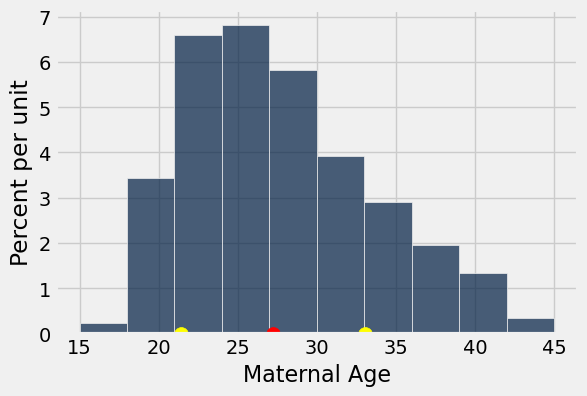

In [9]:
age_mean = np.mean(births.column("Maternal Age"))
age_sd = np.std(births.column("Maternal Age"))
births.hist("Maternal Age")

plt.scatter(age_mean, 0, color='red', s=100, zorder=2);
plt.scatter(age_mean+age_sd, 0, color='yellow', s=100, zorder=2);
plt.scatter(age_mean-age_sd, 0, color='yellow', s=100, zorder=2);

In this histogram, the standard deviation is not easy to identify just by looking at the graph.

However, the distributions of some variables allow us to easily spot the standard deviation on the plot. For example, if a sample follows a *normal distribution*, the standard deviation is easily spotted at the point of inflection (the point where the curve begins to change the direction of its curvature) of the distribution. 

**Question 1.3.** Fill in the following code to examine the distribution of maternal heights, which is roughly normally distributed. We’ll plot the standard deviation on the histogram, as before - notice where one standard deviation (yellow) away from the mean (red) falls on the plot.

<!--
BEGIN QUESTION
name: q1_3
-->

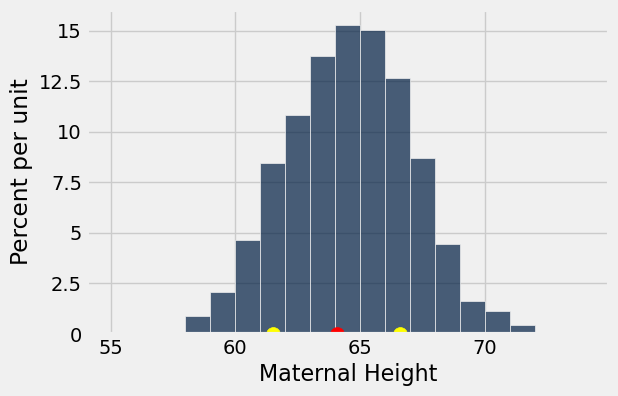

In [10]:
height_mean = np.mean(births.column("Maternal Height"))
height_sd = np.std(births.column("Maternal Height"))
births.hist("Maternal Height", bins=np.arange(55,75,1))

plt.scatter((height_mean), 0, color='red', s=100, zorder=2);
plt.scatter(height_mean+height_sd, 0, color='yellow', s=100, zorder=2);
plt.scatter(height_mean-height_sd, 0, color='yellow', s=100, zorder=2);

We don’t always know how a variable will be distributed, and making assumptions about whether or not a variable will follow a normal distribution is dangerous. However, the Central Limit Theorem defines one distribution that always follows a normal distribution. The distribution of the *sums* and *means* of many large random samples drawn with replacement from a single distribution (regardless of the distribution’s original shape) will be normally distributed. Remember that the Central Limit Theorem refers to the distribution of a *statistic* calculated from a distribution, not the distribution of the original sample or population.

The next section will explore distributions of sample means, and you will see how the standard deviation of these distributions depends on sample sizes.

# 2. Variability of the Sample Mean

By the [Central Limit Theorem](https://www.inferentialthinking.com/chapters/14/4/Central_Limit_Theorem.html), the probability distribution of the mean of a large random sample is roughly normal. The bell curve is centered at the population mean. Some of the sample means are higher and some are lower, but the deviations from the population mean are roughly symmetric on either side, as we have seen repeatedly. Formally, probability theory shows that the sample mean is an **unbiased estimate** of the population mean.

In our simulations, we also noticed that the means of larger samples tend to be more tightly clustered around the population mean than means of smaller samples. In this section, we will quantify the [variability of the sample mean](https://www.inferentialthinking.com/chapters/14/5/Variability_of_the_Sample_Mean.html) and develop a relation between the variability and the sample size.

Let's take a look at the salaries of permanent employees of UNC Chapel Hill as of September 2021. 

In [11]:
salaries = Table.read_table('UNC_CH_Salaries.csv')
salaries

BASE_SALARY
61000
154000
186430
59000
50000
114101
37256
127834
53010
199610


In [12]:
salary_mean = np.mean(salaries.column('BASE_SALARY'))
print('Mean salary of UNC-CH employees in September 2021 is: ', round(salary_mean, 2))

Mean salary of UNC-CH employees in September 2021 is:  94922.71


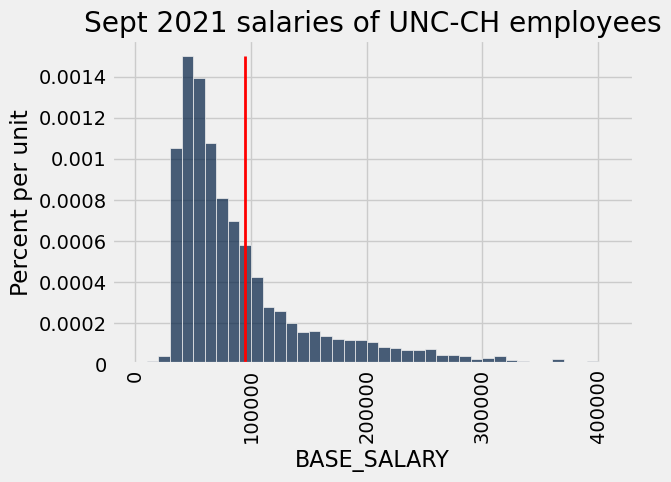

In [13]:
# This plot may produce a warning message, which is fine.
# Running this cell a second time should dismiss the warning.

salaries.hist('BASE_SALARY', bins=np.arange(0, 400000+10000*2, 10000))
plt.plot([salary_mean, salary_mean], [0, 0.000015], color='red', lw=2);
plt.title('Sept 2021 salaries of UNC-CH employees');

Clearly, the population does not follow a normal distribution. Keep that in mind as we progress through these exercises.

Let's take random samples *with replacement* and look at the probability distribution of the sample mean. As usual, we will use simulation to get an empirical approximation to this distribution.

**Question 2.1.** Define a function `one_sample_mean`. Its arguments should be `table` (the name of a table), `label` (the label of the column containing the variable), and `sample size`(the number of employees in the sample). It should sample with replacement from the table and
return the mean of the `label` column of the sample.

<!--
BEGIN QUESTION
name: q2_1
-->

In [14]:
def one_sample_mean(table, label, sample_size):
    new_sample = table.sample(sample_size)
    new_sample_mean = np.mean(new_sample.column(label))
    return new_sample_mean

**Question 2.2.** Use `one_sample_mean` to define a function `simulate_sample_mean`. The arguments are the name of the table, the label of the column containing the variable, the sample size, and the number of simulations.

The function should sample with replacement from the table and calculate the mean of each sample. It should save the sample means in an array called `means`. The remaining code in the function displays an empirical histogram of the sample means.

<!--
BEGIN QUESTION
name: q2_2
-->

In [15]:
"""Empirical distribution of random sample means"""

def simulate_sample_mean(table, label, sample_size, repetitions):
    
    means = make_array()

    for i in np.arange(repetitions):
        new_sample_mean = one_sample_mean(table, label, sample_size)
        means = np.append(means, new_sample_mean)

    sample_means = Table().with_column('Sample Means', means)
    
    # Display empirical histogram and print all relevant quantities – don't change this!
    sample_means.hist(bins=30)
    plt.xlabel('Sample Means')
    plt.title('Sample Size ' + str(sample_size))
    print("Sample size: ", sample_size)
    print("Population mean:", np.mean(table.column(label)))
    print("Average of sample means: ", np.mean(means))
    print("Population SD:", np.std(table.column(label)))
    print("SD of sample means:", np.std(means))
    return np.std(means)

If you haven't implemented this function correctly, the rest of the lab won't work properly, so this step is crucial!

 In the following cell, we will create a sample of size 100 from `salaries` and graph it using our new `simulate_sample_mean` function.
 
 *Hint: You should see a distribution similar to something we've been talking about. If not, check your function*

Sample size:  100
Population mean: 94922.705688
Average of sample means:  94859.2092259
Population SD: 74794.2991078
SD of sample means: 7479.8111212


7479.811121196065

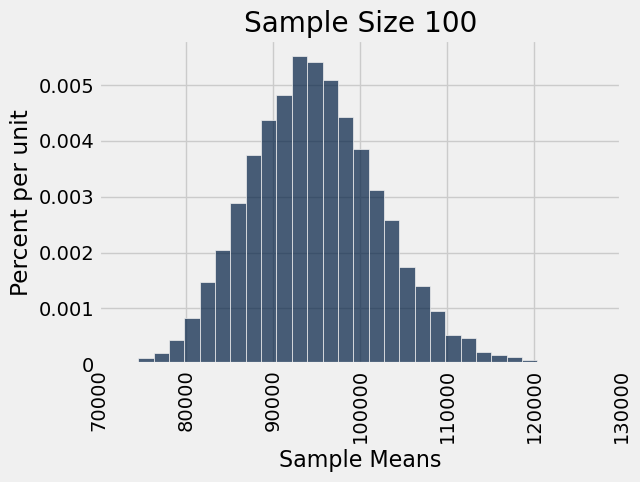

In [16]:
simulate_sample_mean(salaries, 'BASE_SALARY', 100, 10000)

**Question 2.3.** Simulate two sample means, one for a sample of 400 salaries and one for a sample of 625 salaries. In each case, perform 10,000 repetitions. 

<!--
BEGIN QUESTION
name: q2_3
-->

Sample size:  400
Population mean: 94922.705688
Average of sample means:  95022.7360838
Population SD: 74794.2991078
SD of sample means: 3721.79088044


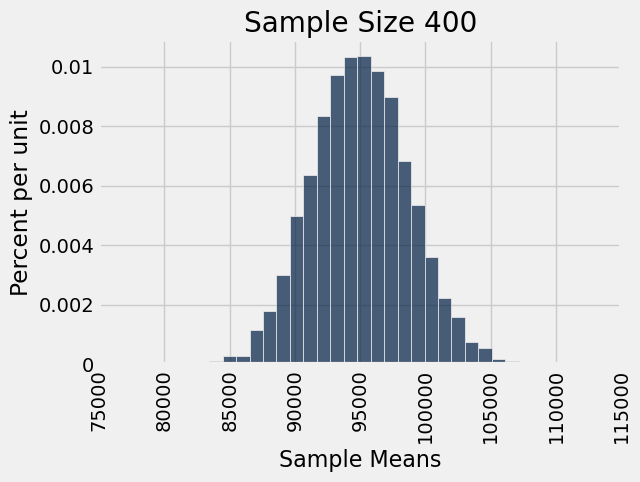



Sample size:  625
Population mean: 94922.705688
Average of sample means:  94995.0402364
Population SD: 74794.2991078
SD of sample means: 2989.08928582


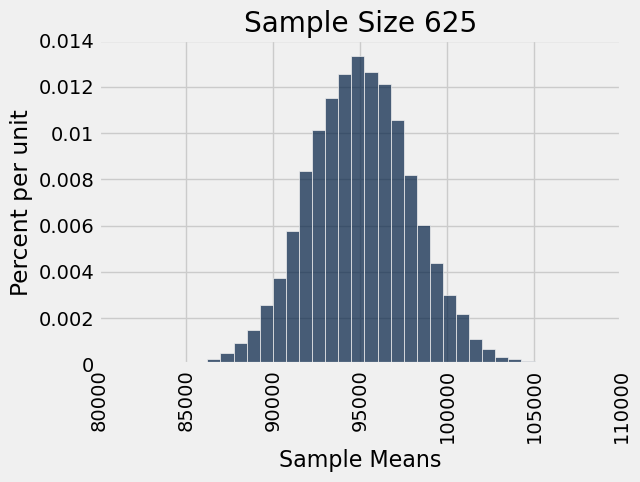

In [17]:
simulate_sample_mean(salaries, 'BASE_SALARY', 400, 10000)
plt.show();
print('\n')
simulate_sample_mean(salaries, 'BASE_SALARY', 625, 10000)
plt.show();

**Question 2.4.** Assign `q2_4` to an array of numbers corresponding to true statement(s) about the plots from 2.3.

1. We see the Law of Averages in action because the distributions of the sample means look like the distribution of the population. 
2. We see the Central Limit Theorem (CLT) in action because the distributions of the sample means are bell-shaped.
3. One of the conditions for CLT is that the population must be normally distributed.
4. One of the conditions for CLT is that we have to draw a small random sample with replacement from the population.
5. One of the conditions for CLT is that we have to draw a large random sample with replacement from the population.
6. Both plots in 2.3 are roughly centered around the mean of a particular sample. 
7. Both plots in 2.3 are roughly centered around the population mean.
8. The distribution of sample means for sample size 625 has more variability than the distribution of sample means for sample size 400.
9. The distribution of sample means for sample size 625 has less variability than the distribution of sample means for sample size 400.

<!--
BEGIN QUESTION
name: q2_4
-->

In [19]:
q2_4 = make_array(2,5,7,9)

Below, we'll look at what happens when we take an increasing number of resamples of a fixed sample size. Notice what number in the code changes, and what stays the same. How does the distribution of the resampled means change?

In [ ]:
simulate_sample_mean(salaries, 'BASE_SALARY', 100, 500)

In [ ]:
simulate_sample_mean(salaries, 'BASE_SALARY', 100, 1000)

In [ ]:
simulate_sample_mean(salaries, 'BASE_SALARY', 100, 5000)

In [ ]:
simulate_sample_mean(salaries, 'BASE_SALARY', 100, 10000)

What did you notice about the distributions of sample means in the four histograms above? 

**Question 2.5.** Assign the variable `SD_of_sample_means` to the integer corresponding to your answer to the following question:

When I increase the number of resamples that I take, for a fixed sample size, the SD of my sample means will...

1. Increase
2. Decrease
3. Vary widly
4. Stay about the same


<!--
BEGIN QUESTION
name: q2_5
-->

In [20]:
SD_of_sample_means = 4

**Question 2.6.** Let's think about how the relationships between population SD, sample SD, and SD of sample means change with varying sample size. Which of the following is true? Assign the variable `pop_vs_sample` to an array of integer(s) that correspond to true statement(s).

1. Sample SD becomes more consistent with population SD with increasing sample size. 
2. Sample SD gets smaller with increasing sample size.
3. Sample SD gets larger with increasing sample size.
4. SD of sample means stays the same with increasing sample size.
5. SD of sample means gets smaller with increasing sample size.
6. SD of sample means gets larger with increasing sample size. 

<!--
BEGIN QUESTION
name: q2_6
-->

In [27]:
pop_vs_sample = make_array(1,5)

Run the following three cells multiple times and examine how the sample SD and the SD of sample means change with sample size.

The first histogram is of the sample; the second histogram is the distribution of sample means with that particular sample size. You may adjust the bins as necessary.

Sample SD:  25077.1504168
Sample size:  10
Population mean: 94922.705688
Average of sample means:  95366.252998
Population SD: 74794.2991078
SD of sample means: 23866.3211469


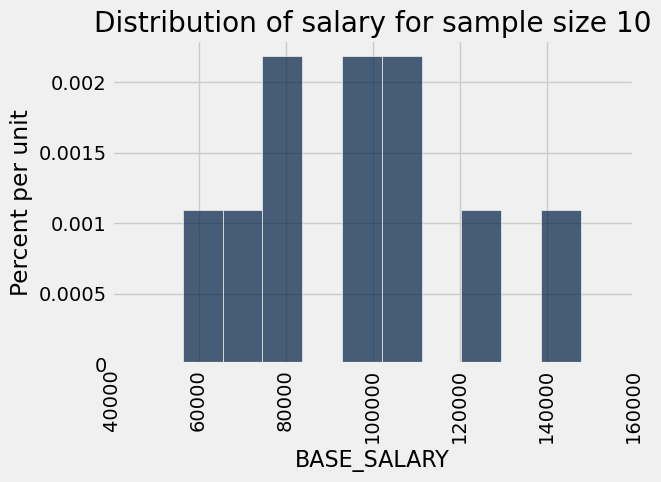

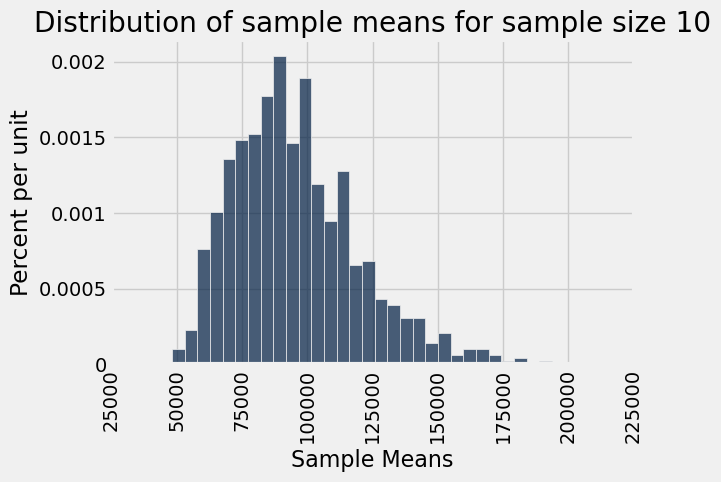

In [21]:
sample_10 = salaries.sample(10)
sample_10.hist('BASE_SALARY')
plt.title('Distribution of salary for sample size 10')
print("Sample SD: ", np.std(sample_10.column('BASE_SALARY')))
simulate_sample_mean(salaries, 'BASE_SALARY', 10, 1000)
plt.title('Distribution of sample means for sample size 10');

Sample SD:  91146.5793501
Sample size:  200
Population mean: 94922.705688
Average of sample means:  94901.2126729
Population SD: 74794.2991078
SD of sample means: 5331.63356196


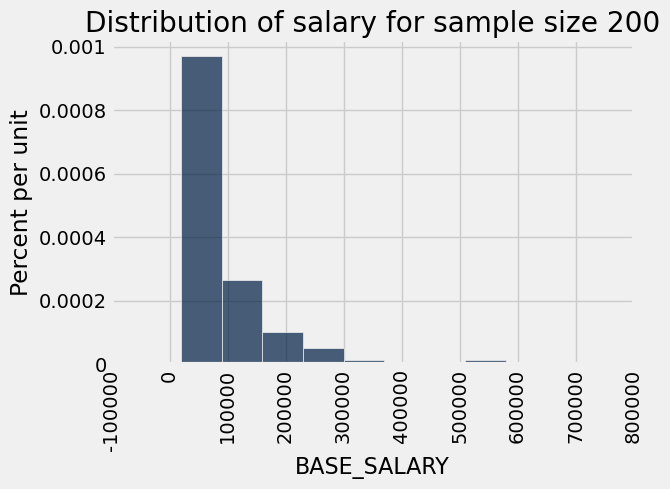

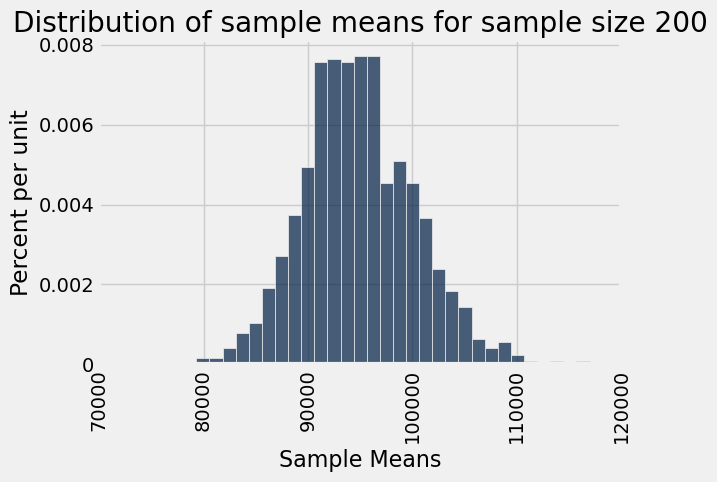

In [22]:
sample_200 = salaries.sample(200)
sample_200.hist('BASE_SALARY')
plt.title('Distribution of salary for sample size 200')
print("Sample SD: ", np.std(sample_200.column('BASE_SALARY')))
simulate_sample_mean(salaries, 'BASE_SALARY', 200, 1000)
plt.title('Distribution of sample means for sample size 200');

Sample SD:  77628.8586068
Sample size:  1000
Population mean: 94922.705688
Average of sample means:  94818.991971
Population SD: 74794.2991078
SD of sample means: 2295.51743535


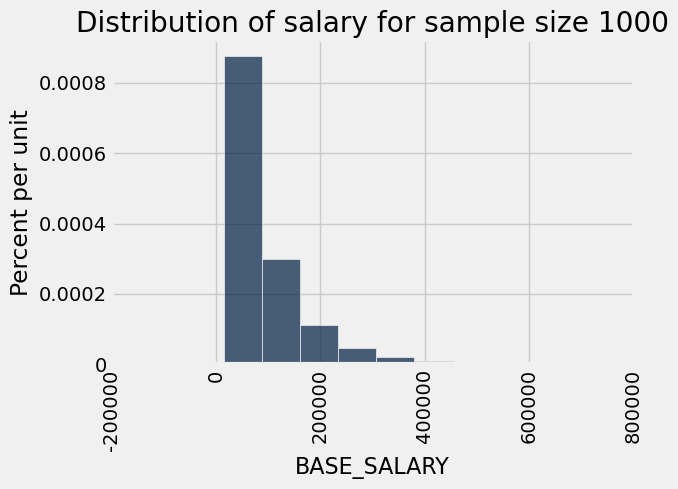

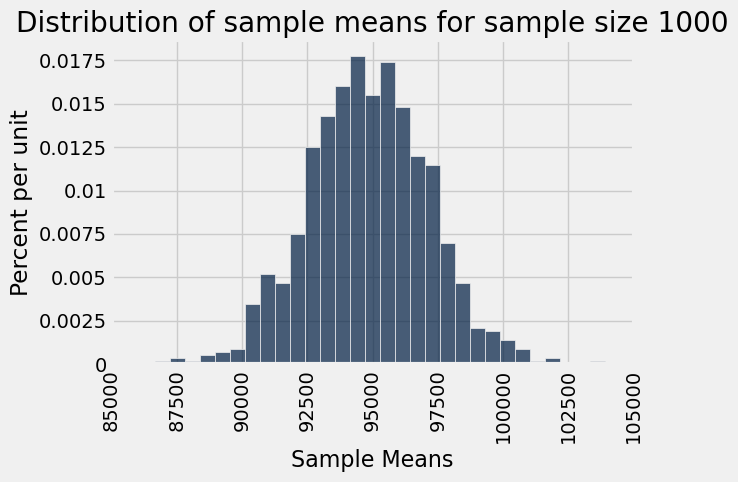

In [23]:
sample_1000 = salaries.sample(1000)
sample_1000.hist('BASE_SALARY')
plt.title('Distribution of salary for sample size 1000')
print("Sample SD: ", np.std(sample_1000.column('BASE_SALARY')))
simulate_sample_mean(salaries, 'BASE_SALARY', 1000, 1000)
plt.title('Distribution of sample means for sample size 1000');

You should notice that the distribution of means gets narrower and spikier, and that the distribution of the sample increasingly looks like the distribution of the population as we get to larger sample sizes. 

Let's illustrate these trends. Below, you will see how the sample SD changes with respect to sample size (N). The blue line is the population SD.

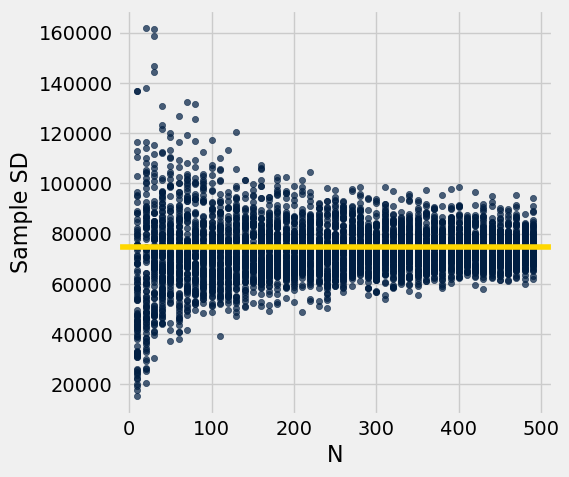

In [24]:
# Don't change this cell, just run it!
pop_sd = np.std(salaries.column('BASE_SALARY'))
sample_sds = make_array()
sample_sizes = make_array()
for i in np.arange(10, 500, 10):
    sample_sds = np.append(sample_sds, [np.std(salaries.sample(i).column('BASE_SALARY')) for d in np.arange(100)])
    sample_sizes = np.append(sample_sizes, np.ones(100) * i)
Table().with_columns("Sample SD", sample_sds, "N", sample_sizes).scatter("N", "Sample SD")
matplotlib.pyplot.axhline(y=pop_sd, color='gold', linestyle='-');

The next cell shows how the SD of the sample means changes relative to the sample size (N).

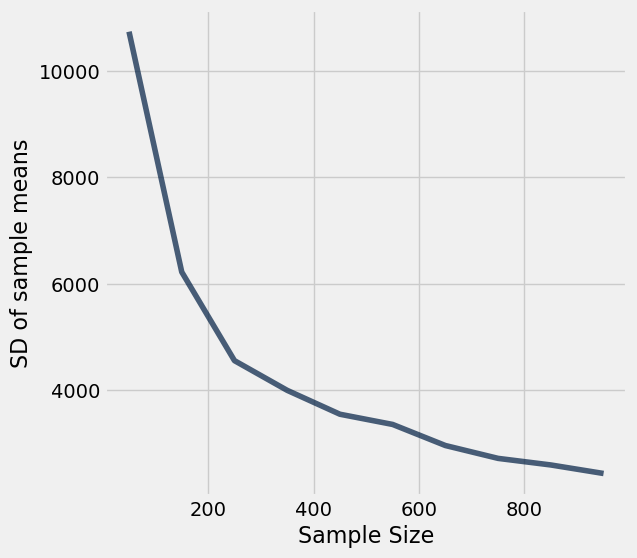

In [25]:
# Don't change this cell, just run it!
def sample_means(sample_size):
    means = make_array()
    for i in np.arange(1000):
        sample = salaries.sample(sample_size).column('BASE_SALARY')
        means = np.append(means, np.mean(sample))
    return np.std(means)

sample_mean_SDs = make_array()
for i in np.arange(50, 1000, 100):
    sample_mean_SDs = np.append(sample_mean_SDs, sample_means(i))
Table().with_columns("SD of sample means", sample_mean_SDs, "Sample Size", np.arange(50, 1000, 100))\
.plot("Sample Size", "SD of sample means")

From these two plots, we can see that the SD of our *sample* approaches the SD of our population as our sample size increases, but the SD of our *sample means* (in other words, the variability of the sample mean) decreases as our sample size increases.

**Question 2.7.** Is there a relationship between the sample size and the standard deviation of the sample mean? Assign `q2_7` to the number corresponding to the statement that answers this question.

1. The SD of the sample means is directly proportional to the square root of sample size. 
2. The SD of the sample means is inversely proportional to the square root of sample size.

<!--
BEGIN QUESTION
name: q2_7
-->

In [26]:
q2_7 = 2

Throughout this homework, we have been taking many random samples from a population. However, all of these principles hold for bootstrapped resamples from a single sample. If your original sample is relatively large, all of your re-samples will also be relatively large, and so the SD of resampled means will be relatively small. 

In order to change the variability of your sample mean, you’d have to change the size of the original sample from which you are taking bootstrapped resamples.

## 3. The CLT and Book Reviews

Your friend has recommended that you read the book [*Data Feminism* by D'Ignazio and Klein](https://www.amazon.com/Feminism-Strong-Ideas-Catherine-DIgnazio-ebook/dp/B08BT3SY5N/ref=sr_1_1?crid=23323Z3L746DV&keywords=data+feminism&qid=1647700779&sprefix=data+feminism%2Caps%2C58&sr=8-1), so you look for it on Amazon. You decide to look at reviews for the book just to be sure that it's worth buying. The book has 170 ratings, but only 22 reviews (at the time of writing this homework), with more than 90% of the ratings for 5 stars. `DF_reviews.csv` contains the number of stars (on a 1-5 scale) for the 22 reviews. 

Here, we've loaded in the table for you.

In [28]:
DF_reviews = Table.read_table("DF_reviews.csv") 
DF_reviews

Rating
5
5
5
5
5
5
5
5
5
5


**Question 3.1**. Calculate the average star ratings from your sample of Amazon reviews and assign it to `initial_sample_mean`.

<!--
BEGIN QUESTION
name: q3_1
manual: false
-->

In [29]:
initial_sample_mean = np.mean(DF_reviews.column("Rating"))
initial_sample_mean

4.8181818181818183

You've calculated the average star ratings from your sample, so now you want to do some inference using this information. 

**Question 3.2**. First, simulate 10,000 bootstrap resamples of the average star ratings. For each bootstrap resample, calculate the resample mean and store the resampled means in an array called `resample_star_ratings`. Then, plot a histogram of the resampled means.

<!--
BEGIN QUESTION
name: q3_2
manual: false
-->

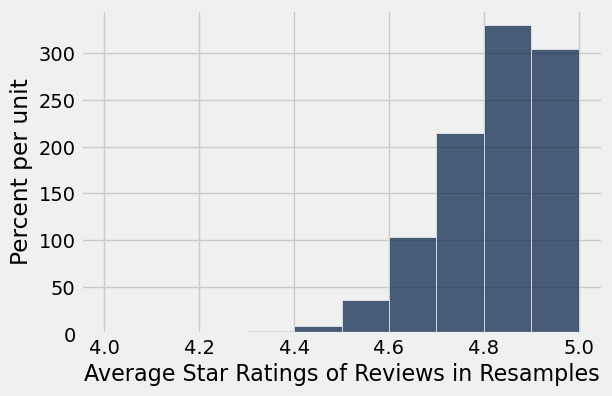

In [36]:
resample_star_ratings = make_array()

for i in np.arange(10000):
    resample = DF_reviews.sample().column("Rating")
    resample_avg_rating = np.mean(resample)
    resample_star_ratings = np.append(resample_star_ratings, resample_avg_rating)
    
# Do NOT change these lines.
Table().with_column(
    "Average Star Ratings of Reviews in Resamples", 
    resample_star_ratings
).hist("Average Star Ratings of Reviews in Resamples", bins = np.arange(4, 5.01, 0.1))

**Question 3.3**. What is the the shape of the empirical distribution of the average star ratings based on our original sample? What value is the distribution centered at? Assign your answer to the variable `initial_sample_mean_distribution`--your answer should be either `1`, `2`, `3`, or `4` corresponding to the following choices:

1. The distribution is approximately normal because of the Central Limit Theorem, and it is centered at the original sample mean.
2. The distribution is not necessarily normal because the Central Limit Theorem may not apply, and it is centered at the original sample mean.
3. The distribution is approximately normal because of the Central Limit Theorem, but it is not centered at the original sample mean.
4. The distribution is not necessarily normal because the Central Limit Theorem may not apply, and it is not centered at the original sample mean.

<!--
BEGIN QUESTION
name: q3_3
manual: false
-->

In [30]:
initial_sample_mean_distribution = 3

According to the Central Limit Theorem, the probability distribution of the sum or average of a *large random sample* drawn with replacement will be roughly normal, regardless of the distribution of the population from which the sample is drawn. 

**Question 3.4**. Note the statement about the sample being large and random. Is this sample large and random? Give a brief explanation.

*Note: The setup at the beginning of this exercise explains how the sample was gathered.*

<!--
BEGIN QUESTION
name: q3_4
manual: true
-->
<!-- EXPORT TO PDF -->

The sample is not large and not random since only ratings with selected reviews were included, then were bootstraped and resampled a great number of times.

Though you have an estimate of the true star ratings of reviews, you want to measure how variable this estimate is. 

**Question 3.5**. Find the standard deviation of your resampled average star ratings, which you stored in `resample_star_ratings`, and assign the result to the variable `resampled_means_variability`.

<!--
BEGIN QUESTION
name: q3_5
manual: false
-->

In [39]:
resampled_means_variability = np.std(resample_star_ratings)
resampled_means_variability

0.12113785467272699

That doesn't seem like much variability in the ratings, but let's look at a larger collections of reviews from [Goodreads.com](https://www.goodreads.com/book/show/51777543-data-feminism). Goodreads has 630 ratings for the book, with 99 of those including a written review (at the time of writing this homework). The ratings for the reviews are loaded into the table `more_DF_reviews`.

In [37]:
# Just run this cell
more_DF_reviews = Table.read_table("more_DF_reviews.csv")
more_DF_reviews

Rating
5
5
5
5
5
5
5
5
5
5


In the next few questions, we'll test an important result of the Central Limit Theorem. According to the CLT, the standard deviation of all possible sample means can be calculated using the following formula:

$$
\text{SD of all possible sample means} = \dfrac{\text{Population SD}}{\sqrt{\text{sample size}}}
$$

This formula gives us another way to approximate the SD of the sample means other than calculating it empirically. We can test how well this formula works by calculating the SD of sample means for different sample sizes.

The following code calculates the SD of sample means using the CLT and empirically for a range of sample sizes. Then, it plots a scatter plot comparing the SD of the sample means calculated with both methods. Each point corresponds to a different sample size. 

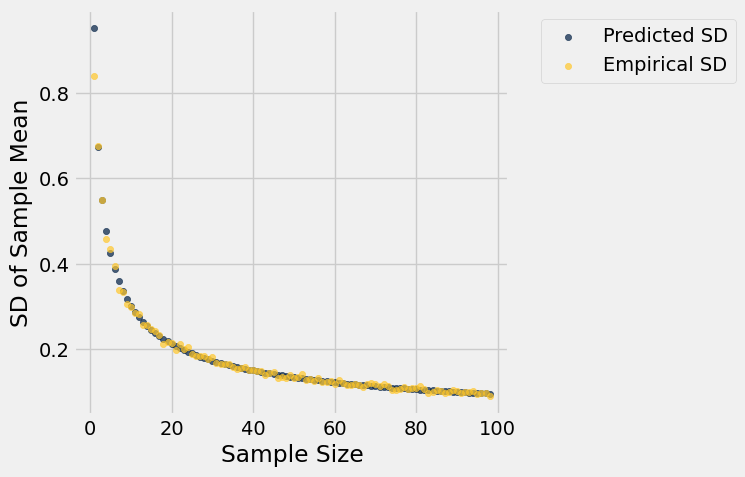

In [40]:
# Just run this cell. It's not necessary for you to read this code, but you can do 99% of this on your own!
# Note: this cell might take a bit to run.

def empirical_sample_mean_sd(n):
    sample_means = make_array()
    for i in np.arange(500):
        sample = more_DF_reviews.sample(n).column('Rating') 
        sample_mean = np.mean(sample) 
        sample_means = np.append(sample_means, sample_mean) 
    return np.std(sample_means)

def predict_sample_mean_sd(n):
    return np.std(more_DF_reviews.column(0)) / (n**0.5)

sd_table = Table().with_column('Sample Size', np.arange(1,99))
predicted = sd_table.apply(predict_sample_mean_sd, 'Sample Size')
empirical = sd_table.apply(empirical_sample_mean_sd, 'Sample Size')
sd_table = sd_table.with_columns('Predicted SD', predicted, 'Empirical SD', empirical)
sd_table.scatter('Sample Size')
plt.ylabel("SD of Sample Mean");

**Question 3.6**. Assign the numbers corresponding to all true statements to an array called `sample_mean_sd_statements`. 
1. The plot above shows that as our sample size increases, our estimate for the true average star ratings becomes more accurate. 
2. The SD of the sample means is proportional to the square root of the sample size.
3. The law of large numbers tells us that the distribution of a large random sample should resemble the distribution from which it is drawn.  
4. The SD of the sample means is proportional to 1 divided by the square root of the sample size. 
5. The law of large numbers guarantees that empirical and predicted sample mean SDs will be approximately equal to each other when the sample size is large.
6. The law of large numbers guarantees that empirical and predicted sample mean SDs will be exactly equal to each other when the sample size is large.
7. The plot above shows that the size of the population affects the SD of the sample means.


<!--
BEGIN QUESTION
name: q3_6
manual: false
-->

In [41]:
sample_mean_sd_statements = make_array(1,3,4,5)

Often times, when conducting statistical inference, you'll want your estimate of a population parameter to have a certain accuracy. It is common to measure accuracy of an estimate using the SD of the estimate--as the SD goes down, your estimate becomes less variable. As a result, the width of the confidence interval for your estimate decreases (think about why this is true). We know from the Central Limit Theorem that when we estimate a sample mean, the SD of the sample mean decreases as the sample size increases (again, think about why this is true).  

**Question 3.7**. Imagine you are asked to estimate the true average star rating for this book and you have not yet taken a sample of reviews. Which of these is the best way to decide how large your sample should be to achieve a certain level of accuracy for your estimate of the true average star rating? Assign `sample_size_calculation` to either `1`, `2`, or `3` corresponding to the statements below.

*Note: Assume that you know the population SD or can estimate it with reasonable accuracy.*
1. Take many random samples of different sizes, then calculate empirical confidence intervals using the bootstrap until you reach your desired accuracy. 
2. Randomly pick a sample size and hope for the best.
3. Use the Central Limit Theorem to calculate what sample size you need in advance.

<!--
BEGIN QUESTION
name: q3_7
manual: false
-->

In [32]:
sample_size_calculation = 3

## 4. The CLT and Book Reviews - Determining Accuracy

Rather than look at the star ratings of the reviews, let's instead look at the proportion of positive reviews. We'll consider reviews to be positive if they have a star rating of either 4 or 5. 

**Question 4.1** Construct a new table `more_DF_reviews_positive`. This table should have the same `Rating` column as `more_DF_reviews` as well as a second column `Positive`. The value of `Positive` should be `1` if the star rating for the review is a `4` or `5` and a `0` if the star rating for the review is `1`, `2`, or `3`.

In [58]:
positive = make_array()

for i in np.arange(more_DF_reviews.num_rows):
    if more_DF_reviews.column("Rating").item(i) == 5:
        positive = np.append(positive, 1)
    elif more_DF_reviews.column("Rating").item(i) == 4:
        positive = np.append(positive, 1)
    else:
        positive = np.append(positive, 0)
    
more_DF_reviews_positive = more_DF_reviews.with_column("Positive", positive)

**Question 4.2**. Simulate 10,000 bootstrap resamples of the proportion of positive results from the GoodReads reviews. For each bootstrap resample, calculate the proportion of positive reviews and store the resampled proportions in an array called `resamples_positive_prop`. Then, plot a histogram of the resampled proportions.

<!--
BEGIN QUESTION
name: q4_2
manual: false
-->

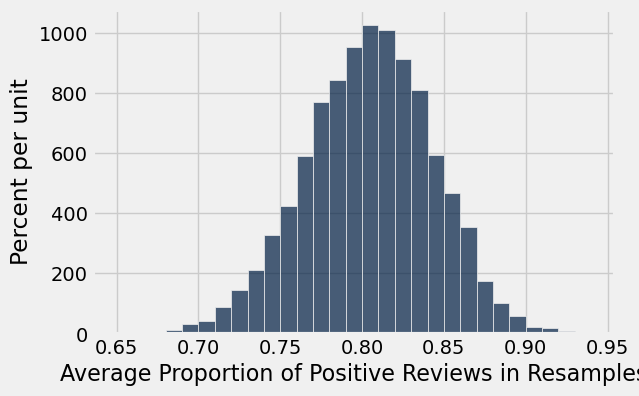

In [56]:
resamples_positive_prop = make_array()

for i in np.arange(10000):
    resample2 = more_DF_reviews_positive.sample()
    resample2_positive_prop = resample2.where("Positive", 1).num_rows / resample2.num_rows
    resamples_positive_prop = np.append(resamples_positive_prop, resample2_positive_prop)
    
# Do NOT change these lines.
Table().with_column(
    "Average Proportion of Positive Reviews in Resamples", 
    resamples_positive_prop
).hist("Average Proportion of Positive Reviews in Resamples", bins = np.arange(0.65, 0.95, 0.01))

**Question 4.3** Use the `resamples_positive_prop` array from the previous problem to construct a 95% confidence interval for the proportion of people that would review [*Data Feminism* by D'Ignazio and Klein](https://www.amazon.com/Feminism-Strong-Ideas-Catherine-DIgnazio-ebook/dp/B08BT3SY5N/ref=sr_1_1?crid=23323Z3L746DV&keywords=data+feminism&qid=1647700779&sprefix=data+feminism%2Caps%2C58&sr=8-1) positively. Assign `upper_bound` to the upper bound of your confidence interval and `lower_bound` to the lower bound.

In [57]:
upper_bound = percentile(97.5, resamples_positive_prop)
lower_bound = percentile(2.5, resamples_positive_prop)

print('We predict with 95% confidence that between the proportions of',
      np.round(lower_bound,3),
      'and',
      np.round(upper_bound, 3),
      "of people would review Data Feminism by D'Ignazio and Klein positively"
     )      

We predict with 95% confidence that between the proportions of 0.727 and 0.879 of people would review Data Feminism by D'Ignazio and Klein positively


Suppose that you plan to collect a random sample of reviews from the internet in order to predict what proportion of people would review [*Data Feminism* by D'Ignazio and Klein](https://www.amazon.com/Feminism-Strong-Ideas-Catherine-DIgnazio-ebook/dp/B08BT3SY5N/ref=sr_1_1?crid=23323Z3L746DV&keywords=data+feminism&qid=1647700779&sprefix=data+feminism%2Caps%2C58&sr=8-1) positively. You would like to predict this proportion with at worst $\pm$7% accuracy. How large of a sample of reviews would you need to collect in order to guarantee this? The relationship between the sample size and width of a 95% confidence interval is shown with the following equation:

$$
\sqrt{\mbox{sample size}} ~ \ge ~ 4 \times \frac{\mbox{SD of the 0-1 population}}{\mbox{Width of Confidence Interval}}
$$

**Question 4.4** Use the equation above to determine the size of the sample needed to guarantee the construction of a 95% confidence interval with at worst $\pm$7% accuracy. Assign this value to `sample_size_needed`.

*Hint 1*: What would be the *width* of an interval with $\pm$7% accuracy?

*Hint 2*: Your sample size must be a whole number

In [63]:
sample_size_needed = np.round((7/0.879-0.727) * 4) ** 2
sample_size_needed

841.0

That's it! You've completed homework 9. 